In [ ]:
import pandas as pd
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [31]:
X_train = pd.read_csv('../dataset_preparation/train_test_data/x_train.csv')
X_test = pd.read_csv('../dataset_preparation/train_test_data/x_test.csv')
y_train = pd.read_csv("../dataset_preparation/train_test_data/y_train.csv")
y_test = pd.read_csv("../dataset_preparation/train_test_data/y_test.csv")

In [32]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [33]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [34]:
with open('models/polynomialFeatures.pkl','wb') as file:
    pickle.dump(poly,file)

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [36]:
with open('models/standard_scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

In [37]:
feature_names = [name.replace(' ', '_') for name in poly.get_feature_names_out()]
feature_names

['co',
 'no2',
 'o3',
 'pm10',
 'pm25',
 'so2',
 'hour',
 'city_name_Ahmedabad',
 'city_name_Bengaluru',
 'city_name_Chennai',
 'city_name_Delhi',
 'city_name_Gajuwaka',
 'city_name_Hyderabad',
 'city_name_Kolkata',
 'city_name_Mumbai',
 'city_name_Pune',
 'co^2',
 'co_no2',
 'co_o3',
 'co_pm10',
 'co_pm25',
 'co_so2',
 'co_hour',
 'co_city_name_Ahmedabad',
 'co_city_name_Bengaluru',
 'co_city_name_Chennai',
 'co_city_name_Delhi',
 'co_city_name_Gajuwaka',
 'co_city_name_Hyderabad',
 'co_city_name_Kolkata',
 'co_city_name_Mumbai',
 'co_city_name_Pune',
 'no2^2',
 'no2_o3',
 'no2_pm10',
 'no2_pm25',
 'no2_so2',
 'no2_hour',
 'no2_city_name_Ahmedabad',
 'no2_city_name_Bengaluru',
 'no2_city_name_Chennai',
 'no2_city_name_Delhi',
 'no2_city_name_Gajuwaka',
 'no2_city_name_Hyderabad',
 'no2_city_name_Kolkata',
 'no2_city_name_Mumbai',
 'no2_city_name_Pune',
 'o3^2',
 'o3_pm10',
 'o3_pm25',
 'o3_so2',
 'o3_hour',
 'o3_city_name_Ahmedabad',
 'o3_city_name_Bengaluru',
 'o3_city_name_Chennai',

In [38]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names_out())
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names_out())

In [39]:
from sklearn.model_selection import GridSearchCV

gb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=5, scoring="r2", n_jobs=-1)
gb_grid.fit(X_train_scaled_df, y_train)
best_gb = gb_grid.best_estimator_

In [40]:
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring="r2", n_jobs=-1)
rf_grid.fit(X_train_scaled_df, y_train)
best_rf = rf_grid.best_estimator_

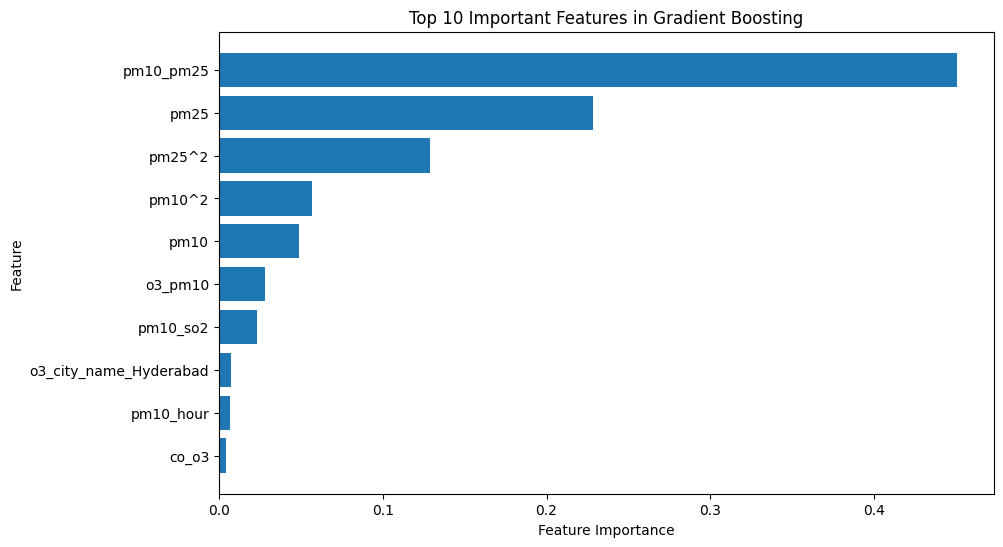

In [41]:
import matplotlib.pyplot as plt

feature_importances = best_gb.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx][-10:], feature_importances[sorted_idx][-10:])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in Gradient Boosting")
plt.show()


In [42]:
from sklearn.ensemble import StackingRegressor

stacked_model = StackingRegressor(
    estimators=[
        ("rf", best_rf),
        ("dt", DecisionTreeRegressor(random_state=42)),
        ("gb", best_gb)
    ],
    final_estimator=GradientBoostingRegressor(random_state=42)
)

stacked_model.fit(X_train_scaled_df, y_train)

y_pred_stacked = stacked_model.predict(X_test_scaled_df)
y_pred_stacked_train = stacked_model.predict(X_train_scaled_df)


stacked_results_train = {
    "MAE": mean_absolute_error(y_train, y_pred_stacked_train),
    "MSE": mean_squared_error(y_train, y_pred_stacked_train),
    "RMSE": np.sqrt(mean_squared_error(y_train, y_pred_stacked_train)),
    "R2": r2_score(y_train, y_pred_stacked_train)
}
stacked_results = {
    "MAE": mean_absolute_error(y_test, y_pred_stacked),
    "MSE": mean_squared_error(y_test, y_pred_stacked),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_stacked)),
    "R2": r2_score(y_test, y_pred_stacked)
}

In [43]:
print("Stacked Model Results on train data:")
print(f"  Mean Absolute Error (MAE): {stacked_results_train['MAE']:.2f}")
print(f"  Mean Squared Error (MSE): {stacked_results_train['MSE']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {stacked_results_train['RMSE']:.2f}")
print(f"  R-squared (R2): {stacked_results_train['R2']:.2f}")

Stacked Model Results on train data:
  Mean Absolute Error (MAE): 2.01
  Mean Squared Error (MSE): 43.09
  Root Mean Squared Error (RMSE): 6.56
  R-squared (R2): 0.98


In [44]:
print("Stacked Model Results:")
print(f"  Mean Absolute Error (MAE): {stacked_results['MAE']:.2f}")
print(f"  Mean Squared Error (MSE): {stacked_results['MSE']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {stacked_results['RMSE']:.2f}")
print(f"  R-squared (R2): {stacked_results['R2']:.2f}")

Stacked Model Results:
  Mean Absolute Error (MAE): 3.45
  Mean Squared Error (MSE): 68.56
  Root Mean Squared Error (RMSE): 8.28
  R-squared (R2): 0.98


In [45]:
results = pd.DataFrame({
    "actual" : y_test,
    "predicitons": y_pred_stacked
})
results

,actual,predicitons
0,146,142.170090
1,188,187.816876
2,93,92.542170
3,156,157.249866
4,94,96.883937
...,...,...
125,240,245.667904
126,177,175.943840
127,187,186.477952
128,207,213.991068


In [46]:
import pickle
with open('models/stacked_ensembled.pkl','wb') as file:
    pickle.dump(stacked_model,file)

In [47]:
model = 'Ensembled_stacked_model'

with open('results/results_train.csv','a') as f:
    f.write(f"{model},{stacked_results_train['MAE']:.2f},{stacked_results_train['MSE']:.2f},{stacked_results_train['RMSE']:.2f},{stacked_results_train['R2']:.2f}\n")


with open('results/results_test.csv','a') as f:
    f.write(f"{model},{stacked_results['MAE']:.2f},{stacked_results['MSE']:.2f}, {stacked_results['RMSE']:.2f},{stacked_results['R2']:.2f}\n")